**Here we perform the training loops**

In [13]:
from DataFrameManager.dataframeManager import DataFrameManager
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import pandas as pd


DATASET_COLUMNS = ["text", "label"]#["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
MODEL_NAME = 'roberta'
NUM_CLASSES = 3


In [18]:
dataFrameManage = DataFrameManager()

train_df = dataFrameManage.load_dataframe(filepath="Data/mock-data/train.csv", encoding=DATASET_ENCODING, preprocess=False)
test_df = dataFrameManage.load_dataframe(filepath="Data/mock-data/test.csv", encoding=DATASET_ENCODING, preprocess=False)

encode_map = {"NEGATIVE" : 0, "POSITIVE" : 1}
    

train_labels = train_df["target"].map(encode_map).to_list()
test_labels = test_df["target"].map(encode_map).to_list()

In [19]:
train_embeddings = np.load(f'Data/mock-data/train_embeddings_{MODEL_NAME}.npy', allow_pickle=True)
test_embeddings = np.load(f'Data/mock-data/test_embeddings_{MODEL_NAME}.npy', allow_pickle=True)

In [ ]:
# # # Start training


# # Define the hyperparameter grid
# param_grid = {
#     'C': [10.0, 50.0],
#     'max_iter': [1000, 1500],
#     'penalty': ['l2']
# }

# # # Create the Logistic Regression classifier
# classifier_lr = LogisticRegression(random_state=42)

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(classifier_lr, param_grid, cv=5)
# grid_search.fit(train_embeddings, train_labels)

# # Get the best hyperparameters and best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Hyperparameters: ", best_params)
# print("Best Score: ", best_score)

# # Fit the model with the best hyperparameters on the entire training data
# best_classifier_lr = LogisticRegression(**best_params)
# best_classifier_lr.fit(train_embeddings, train_labels)

# # Predict on the test set
# predictions_lr = best_classifier_lr.predict(test_embeddings)

# # Calculate the accuracy score
# accuracy_lr = accuracy_score(test_labels, predictions_lr)
# print("Accuracy score for Logistic Regression: ", accuracy_lr)



**SVC**

In [ ]:
# # Train the SVM classifier
# from sklearn import svm


# svm_classifier = svm.SVC()
# svm_classifier.fit(train_embeddings, train_labels)

# # Test the SVM classifier
# predictions = svm_classifier.predict(test_embeddings)
# accuracy = accuracy_score(test_labels, predictions)
# print("Accuracy:", accuracy)

**XGBoost**

In [56]:

# # Define the hyperparameter grid
# param_grid = {
#     'eta': [0.1, 0.3],
#     'max_depth': [3, 6],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'objective': ['multi:softmax'],
#     'num_class': [NUM_CLASSES]
# }

# # Create the XGBoost classifier
# classifier_xgb = xgb.XGBClassifier(random_state=42)

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(classifier_xgb, param_grid, cv=5)
# grid_search.fit(train_embeddings, train_labels)

# # Get the best hyperparameters and best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Hyperparameters: ", best_params)
# print("Best Score: ", best_score)

# # Fit the model with the best hyperparameters on the entire training data
# best_classifier_xgb = xgb.XGBClassifier(**best_params, random_state=42)
# best_classifier_xgb.fit(train_embeddings, train_labels)

# # Predict on the test set
# predictions_xgb = best_classifier_xgb.predict(test_embeddings)

# # Calculate the accuracy score
# accuracy_xgb = accuracy_score(test_labels, predictions_xgb)
# print("Accuracy score for XGBoost: ", accuracy_xgb)

KeyboardInterrupt: 

In [53]:
classifier_xgb = xgb.XGBClassifier(random_state=42, objective='multi:softmax', eta=0.3, max_depth=7, subsample=0.8, colsample_bytree=0.8, num_class = 3)
classifier_xgb.fit(train_embeddings, train_labels)
predictions_xgb = classifier_xgb.predict(test_embeddings)

# Calculate the accuracy score
accuracy_xgb = accuracy_score(test_labels, predictions_xgb)
print("Accuracy score for XGBoost: ", accuracy_xgb)

Accuracy score for XGBoost:  0.7853939621696104


**MLP**

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 2 * hidden_size)
        self.elu1 = nn.ELU()
        self.fc2 = nn.Linear(2 * hidden_size,  hidden_size)
        self.elu2 = nn.ELU()
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):
        x = self.fc1(x)
        x = self.elu1(x)
        x = self.fc2(x)
        x = self.elu2(x)
        x = self.fc3(x)
        x = self.dropout(x)
        return x

# Convert the data to PyTorch tensors
train_embeddings_tensor = torch.tensor(train_embeddings, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_embeddings_tensor = torch.tensor(test_embeddings, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create the neural network model
model = NeuralNetwork(train_embeddings_tensor.shape[1], 256, NUM_CLASSES)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20
batch_size = 32
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

num_batches = int(np.ceil(len(train_embeddings) / batch_size))

best_val_loss = float('inf')
patience = 5
early_stop_counter = 0

with tqdm(total=num_epochs, desc='Epoch', unit='epoch') as pbar:
    for epoch in range(num_epochs):
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        epoch_train_acc = 0.0
        epoch_val_acc = 0.0

        model.train()
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(train_embeddings))
            batch_embeddings = train_embeddings_tensor[start_idx:end_idx]
            batch_labels = train_labels_tensor[start_idx:end_idx]

            optimizer.zero_grad()
            outputs = model(batch_embeddings)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            _, train_predicted_labels = torch.max(outputs, 1)
            epoch_train_acc += accuracy_score(batch_labels.numpy(), train_predicted_labels.numpy())

        epoch_train_loss /= num_batches
        epoch_train_acc /= num_batches

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(test_embeddings_tensor)
            val_loss = criterion(val_outputs, test_labels_tensor)
            epoch_val_loss = val_loss.item()
            _, val_predicted_labels = torch.max(val_outputs, 1)
            epoch_val_acc = accuracy_score(test_labels_tensor.numpy(), val_predicted_labels.numpy())

        train_loss_history.append(epoch_train_loss)
        val_loss_history.append(epoch_val_loss)
        train_acc_history.append(epoch_train_acc)
        val_acc_history.append(epoch_val_acc)

        pbar.set_postfix({'Train Loss': epoch_train_loss, 'Val Loss': epoch_val_loss,
                          'Train Acc': epoch_train_acc, 'Val Acc': epoch_val_acc})
        pbar.update()

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            early_stop_counter = 0
            # Save the model parameters
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered. No improvement in validation loss for {} epochs.".format(patience))
                break

# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

# Convert the tensors to numpy arrays
with torch.no_grad():
    predicted_labels = model(test_embeddings_tensor)
    predicted_labels = torch.argmax(predicted_labels, dim=1).numpy()
    true_labels = test_labels_tensor.numpy()

# Calculate the accuracy score
accuracy_nn = accuracy_score(true_labels, predicted_labels)
print("Accuracy score for Neural Network: ", accuracy_nn)


Epoch:  50%|█████     | 10/20 [02:54<02:54, 17.48s/epoch, Train Loss=0.602, Val Loss=0.429, Train Acc=0.741, Val Acc=0.799]

Early stopping triggered. No improvement in validation loss for 5 epochs.
Accuracy score for Neural Network:  0.8054365526744331


Text(0.5, 1.0, 'RoBERTa Classification')

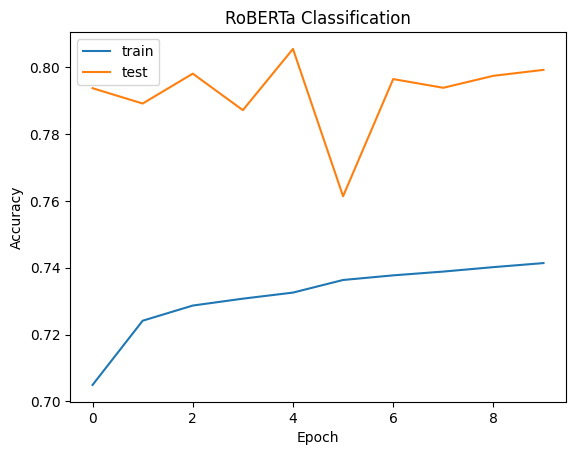

In [26]:
import matplotlib.pyplot as plt
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['train', 'test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('RoBERTa Classification')